<a href="https://colab.research.google.com/github/BankNatchapol/Neuromorphic-Computing/blob/main/sound-localization/coincidence_detection_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://neural-reckoning.github.io/cosyne-tutorial-2022/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

$f$ : Frequency  \
$n_t$ : Number of time steps \
$P_s$ : Phase shift \
$r$ : Number of time steps to phase shift \
range : 0 - $4\pi f$ \
$t = \frac{4\pi f}{10n_t}$ \
$P_s = rt$ \
$r = \frac{10n_t P_s}{4\pi f} $

In [ ]:
frequency = 10
phase_shift = np.pi/2
num_t = 100
seed = 420

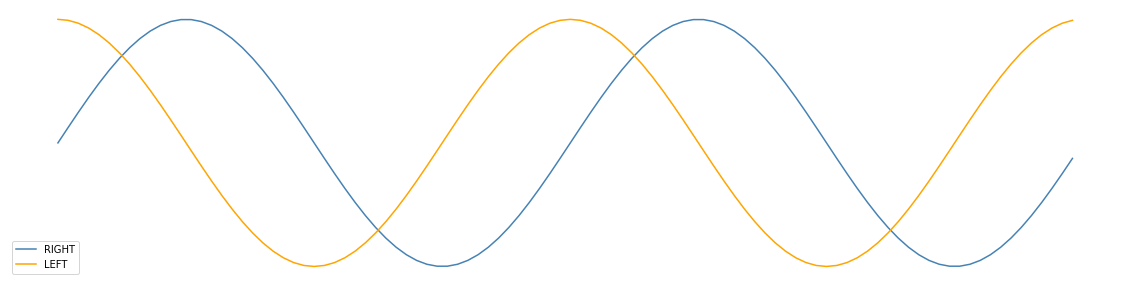

In [ ]:
def generate_input(frequency, phase_shift, num_t, seed):
  
  np.random.seed(seed)
  scale = (4*np.pi*frequency)/10

  right_ear = np.sin(np.linspace(0, scale, num_t + 1))[:-1]
  left_ear = np.sin(np.linspace(0, scale, num_t + 1) + phase_shift)[:-1]

  return right_ear, left_ear

right_ear, left_ear = generate_input(frequency = frequency, phase_shift = phase_shift, num_t = num_t, seed = seed)
plt.figure(figsize=(20, 5))
plt.plot(right_ear, label="RIGHT", color="steelblue")
plt.plot(left_ear, label="LEFT", color="orange")
plt.axis('off')
plt.legend();

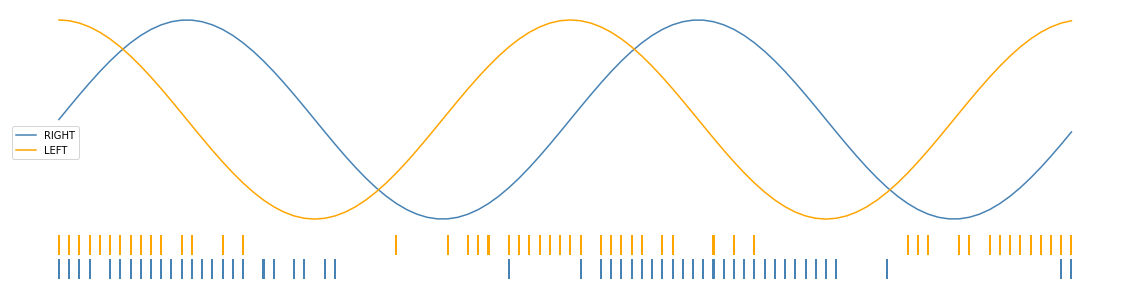

In [ ]:
def generate_spike_train(input_signal):
  probs = (input_signal+1)/2
  spikes = []
  for i in range(len(probs)):
    if np.random.random() < probs[i]:
      spikes.append(1)
    else:
      spikes.append(0)

  return spikes

right_spikes = generate_spike_train(right_ear)
left_spikes = generate_spike_train(left_ear)

plt.figure(figsize=(20, 5))
plt.plot((right_ear+1)/2+0.3, color="steelblue", label="RIGHT")
plt.plot((left_ear+1)/2+0.3, color="orange", label="LEFT")
plt.bar(range(len(right_spikes)), [s*0.1 for s in right_spikes], width=0.2, bottom = 0.0, color="steelblue")
plt.bar(range(len(left_spikes)), [s*0.1 for s in left_spikes], width=0.2, bottom = 0.12, color="orange")
plt.axis('off')
plt.legend();

In [ ]:
# dt unit : ms
def exponential_decay(V, tau = 5, dt = 1):
  newV = (1-dt/tau)*V
  return newV

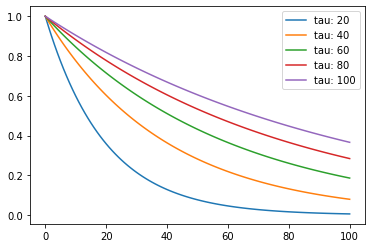

In [ ]:
for tau in range(20, 101, 20):
  potential = 1
  potentials = [potential]
  for __annotations__ in range(100):
    potential = exponential_decay(potential, tau = tau, dt = 1)
    potentials.append(potential)
  plt.plot(potentials, label=f"tau: {tau}")

plt.legend();

In [ ]:
def synaptic_add(V, w = 0.5):
  return V + w

In [ ]:
def fire_spike(V, threshold = 1.0):
  do = False
  if V>threshold:
    V = 0
    do = True
  return V, do

In [ ]:
tau = 5
w = 0.3
fire_threshold = 1.0

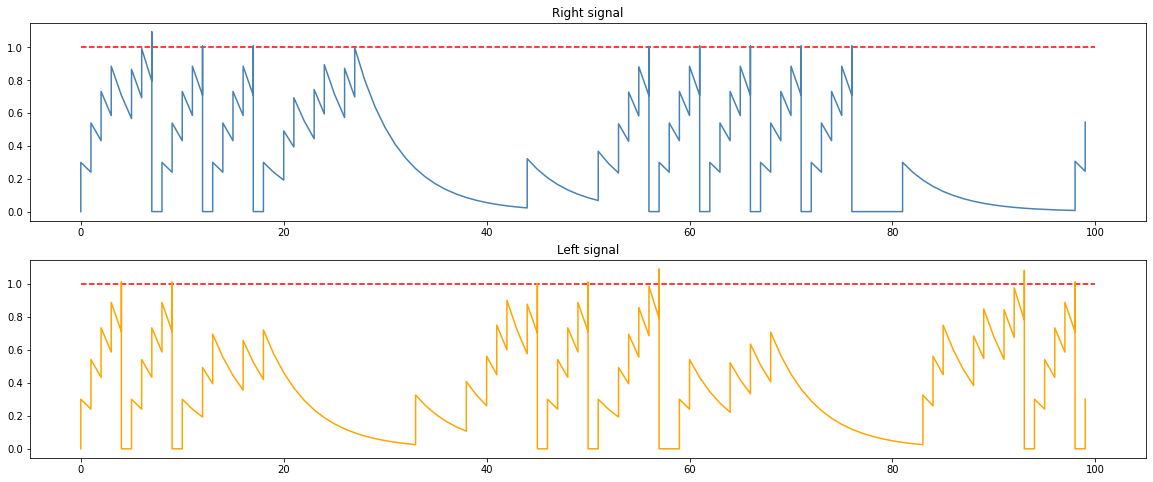

In [ ]:
#@title Membrane potential

def get_membrane_potential(spikes, tau, w, threshold, dt = 1):
  potential = 0
  potentials = []
  times = []
  amplitudes = []
  for i, spike in enumerate(spikes):
    potential = exponential_decay(potential, tau = tau, dt = dt)
    times.append(i)
    potentials.append(potential)
    if spike:
      potential = synaptic_add(potential, w = w)
      times.append(i)
      potentials.append(potential)
      amplitudes.append(potential)
    else:
      amplitudes.append(potential)
      
    potential, do = fire_spike(potential, threshold = threshold)
    if do:
      times.append(i)
      potentials.append(potential)

  return times, potentials, amplitudes
  
right_times, right_potentials, right_amplitudes = get_membrane_potential(right_spikes, 
                                                  tau = tau, 
                                                  w = w, 
                                                  threshold = fire_threshold, 
                                                  dt = 1)

left_times, left_potentials, left_amplitudes = get_membrane_potential(left_spikes, 
                                                  tau = tau, 
                                                  w = w, 
                                                  threshold = fire_threshold, 
                                                  dt = 1)

plt.figure(figsize=(20, 8))
plt.subplot(211, title="Right signal")
plt.plot([fire_threshold]*(right_times[-1]+2), '--', color='red')
plt.plot(right_times, right_potentials, color='steelblue');

plt.subplot(212, title="Left signal")
plt.plot([fire_threshold]*(left_times[-1]+2), '--', color='red')
plt.plot(left_times, left_potentials, color='orange');

In [ ]:
def spike_count(V, threshold = 1.0):
  count = 0
  for p in V:
    if p>threshold:
      count += 1
  return count

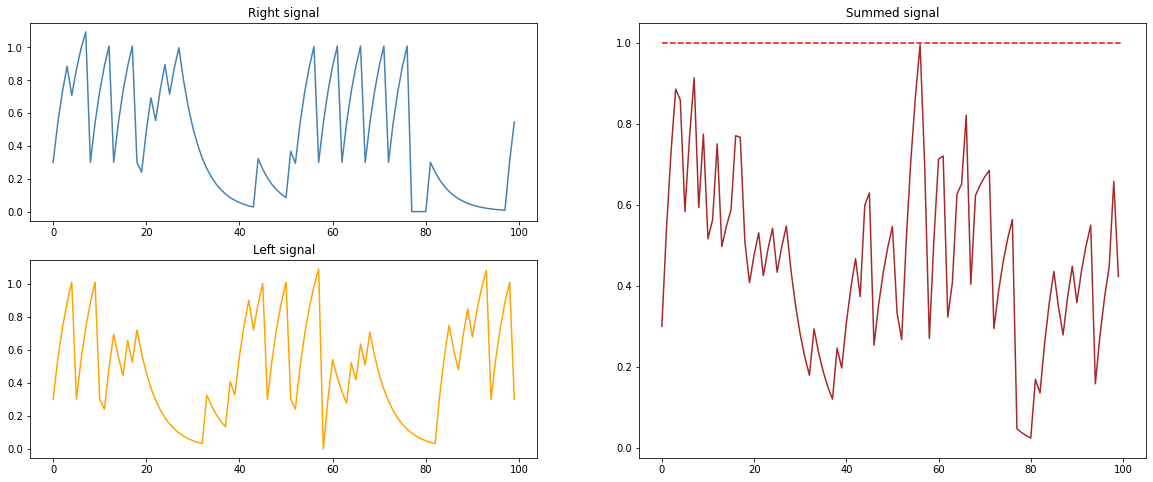

In [ ]:
#@title Summed signal
t_shift =  0# @param {type:'integer'}
left_rolled = np.roll(left_amplitudes, t_shift)
sum_potential = (np.array(right_amplitudes) + left_rolled)/2
plt.figure(figsize=(20, 8))
plt.subplot(221, title="Right signal")
plt.plot(right_amplitudes, color="steelblue")
plt.subplot(223, title="Left signal")
plt.plot(left_rolled, color="orange")
plt.subplot(122, title="Summed signal")
plt.plot([1]*(right_times[-1]+2), '--', color='red')
plt.plot(sum_potential, color="brown");

r list: [8, 14, 19]
Real phase shift      :  90.0 degree
Predicted phase shift :  98.4 degree


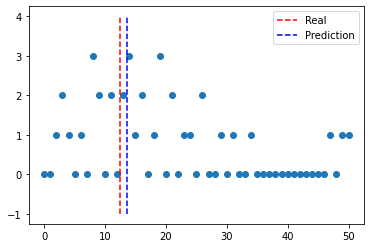

In [ ]:
#@title 
def prediction(left_amplitudes, right_amplitudes, num_t, frequency):
  spike_counts = []
  for t in range(int(5*num_t/frequency)+1):
    left_rolled = np.roll(left_amplitudes, t)
    sum_potential = (np.array(right_amplitudes) + left_rolled)/2
    spike_counts.append(spike_count(sum_potential))

  m = max(spike_counts)
  r_list = [i for i, j in enumerate(spike_counts) if j == m]
  average_r = (sum(r_list)/len(r_list))
  phase_shift_prediction = (180/np.pi)*(average_r * (4*np.pi*frequency)/(10*num_t))

  return phase_shift_prediction, r_list, spike_counts

phase_shift_prediction, r_list, spike_counts = prediction(left_amplitudes, right_amplitudes,
                                                          num_t = num_t, frequency = frequency)

print("r list:", r_list)
print("Real phase shift      : ", phase_shift * (180/np.pi), "degree")
print("Predicted phase shift : ", phase_shift_prediction, "degree")

target_r = phase_shift*(10*num_t)/(4*np.pi*frequency)
average_r = phase_shift_prediction *(10*num_t)/(4*np.pi*frequency*(180/np.pi))
plt.scatter(range(len(spike_counts)), spike_counts)
plt.plot([target_r]*2, [-1, max(spike_counts) + 1], '--', color='red', label='Real')
plt.plot([average_r]*2, [-1, max(spike_counts) + 1], '--', color='blue', label='Prediction')
plt.legend();

In [ ]:
def coincidence_detection(frequency, phase_shift, num_t, tau, w, fire_threshold, seed, dt=1):
  
  right_ear, left_ear = generate_input(frequency = frequency, 
                                       phase_shift = phase_shift, 
                                       num_t = num_t,
                                       seed = seed)
  
  right_spikes = generate_spike_train(right_ear)
  left_spikes = generate_spike_train(left_ear)

  right_times, right_potentials, right_amplitudes = get_membrane_potential(right_spikes, 
                                                  tau = tau, 
                                                  w = w, 
                                                  threshold = fire_threshold, 
                                                  dt = dt)

  left_times, left_potentials, left_amplitudes = get_membrane_potential(left_spikes, 
                                                    tau = tau, 
                                                    w = w, 
                                                    threshold = fire_threshold, 
                                                    dt = dt)
  
  phase_shift_prediction, r_list, spike_counts = prediction(left_amplitudes, right_amplitudes,
                                                            num_t = num_t, frequency = frequency)


  fig = plt.figure(figsize=(20, 5))
  fig.suptitle('Input signal', fontsize=20)
  plt.plot((right_ear+1)/2+0.3, color="steelblue", label="RIGHT")
  plt.plot((left_ear+1)/2+0.3, color="orange", label="LEFT")
  plt.bar(range(len(right_spikes)), [s*0.1 for s in right_spikes], width=0.2, bottom = 0.0, color="steelblue")
  plt.bar(range(len(left_spikes)), [s*0.1 for s in left_spikes], width=0.2, bottom = 0.12, color="orange")
  plt.axis('off')
  plt.legend()

  plt.figure(figsize=(2, 2))
  plt.plot()
  plt.axis('off')
  
  fig = plt.figure(figsize=(20, 8))
  plt.subplot(211)
  fig.suptitle('Membrane Potential', fontsize=20)
  plt.plot([fire_threshold]*(right_times[-1]+2), '--', color='red')
  plt.plot(right_times, right_potentials, label='RIGHT', color='steelblue')
  plt.legend()
  plt.subplot(212)
  plt.plot([fire_threshold]*(left_times[-1]+2), '--', color='red')
  plt.plot(left_times, left_potentials, label='LEFT', color='orange')
  plt.legend()
  

  plt.figure(figsize=(2, 2))
  plt.plot()
  plt.axis('off')

  fig = plt.figure(figsize=(7, 7))
  fig.suptitle('Spike Count', fontsize=20)
  plt.text(-7, -7, f"r list: {r_list}", fontsize=15, color="saddlebrown")
  plt.text(-7, -10, f"Real phase shift        : {phase_shift * (180/np.pi)} degree", fontsize=15, color="saddlebrown")
  plt.text(-7, -13, f"Prediction phase shift  : {phase_shift_prediction} degree", fontsize=15, color="saddlebrown")
  target_r = phase_shift*(10*num_t)/(4*np.pi*frequency)
  average_r = phase_shift_prediction *(10*num_t)/(4*np.pi*frequency*(180/np.pi))
  plt.scatter(range(len(spike_counts)), spike_counts)
  plt.plot([target_r]*2, [-1, max(spike_counts) + 1], '--', color='red', label='Real')
  plt.plot([average_r]*2, [-1, max(spike_counts) + 1], '--', color='blue', label='Prediction')
  plt.legend();

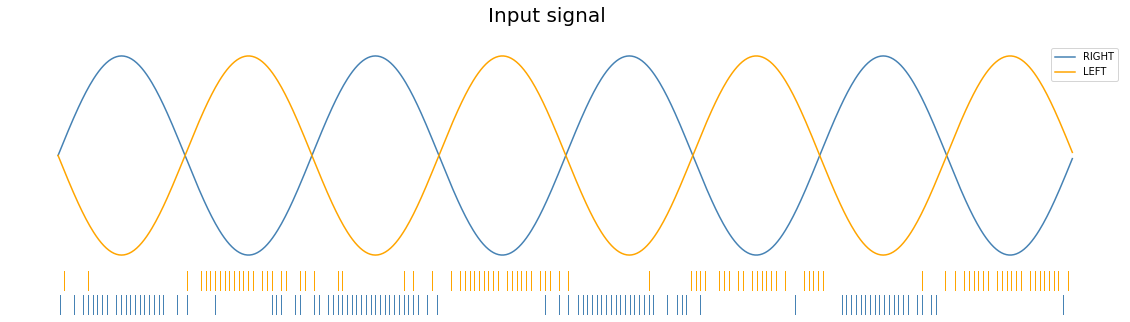

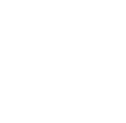

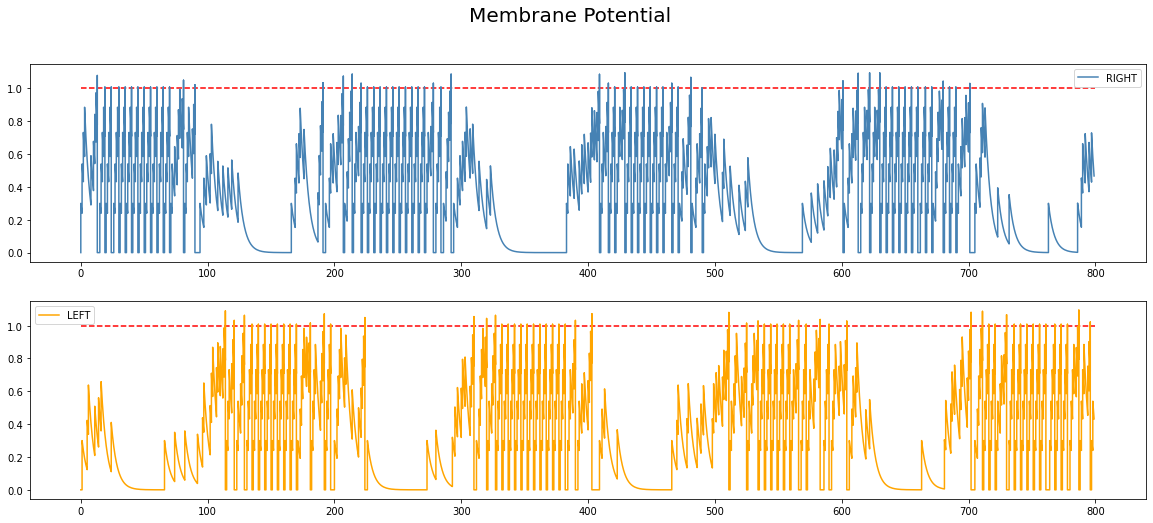

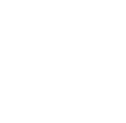

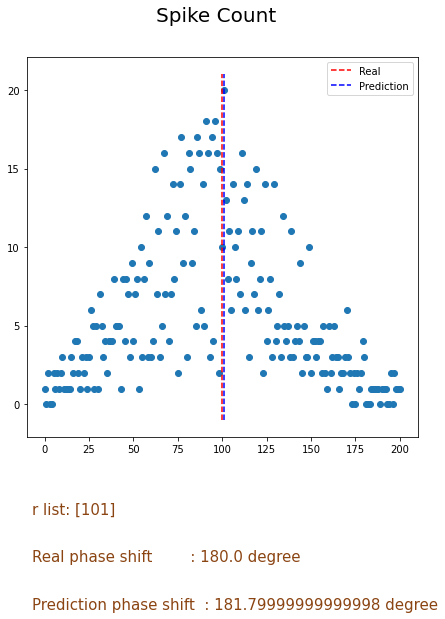

In [ ]:
coincidence_detection(frequency = 20, 
                      phase_shift = np.pi,
                      num_t = 800,
                      tau = 5, 
                      w = 0.3, 
                      fire_threshold = 1.0,
                      seed = 777,
                      dt = 1)